# AIPI 590 - XAI | Assignment #02
### Description: Interpretable ML
### Diya Mirji

#### Include the button below. Change the link to the location in your github repository:
#### Example: https://colab.research.google.com/github/yourGHName/yourREPOName/blob/yourBranchName/yourFileName.ipynb
https://colab.research.google.com/github/dvm14/Duke-XAI/blob/diya-assignment2.ipynb


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dvm14/Duke-XAI/blob/diya-assignment2.ipynb)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-XAI" # Change to your repo name
git_path = 'https://dvm14@github.com/dvm14/Duke-XAI' #Change to your path
!git clone "{git_path}"

!git config --global user.name "dvm14"
!git config --global user.email "dvm14@duke.edu"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
#notebook_dir = 'templates'
#path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{repo_name}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'Duke-XAI' already exists and is not an empty directory.
/content/Duke-XAI
diya_assignment2.ipynb  diya_template.py  README.md  Telco-Customer-Churn.csv


#### Using environment variables in Google Colab

In Google Colab, locate the key button on the left side of the screen. You can enter in any environment variables or API keys here and they will remain private.

Then add the environment variables to your notebook using the code below.

Make sure to document in your notebook if you are using API keys and how to get them (ie share a link for documentation to get a Hugging Face API Key if you are using Hugging Face)

In [2]:
def commit_code():
  !git add .
  !git commit -m "Add data csv"
  !git push

In [3]:
#pip install packages
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pygam

In [4]:
#import packages
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, GammaGAM, s
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import statsmodels.api as sm

In [5]:
#load data
%ls
data = pd.read_csv("/content/Duke-XAI/Telco-Customer-Churn.csv")
print(data.head())
print(data.shape)

X=data.drop(columns=['Churn'])
y=data['Churn']
#print(X.head())
#print(y.head())
print(X.shape, y.shape)

diya_assignment2.ipynb  diya_template.py  README.md  Telco-Customer-Churn.csv
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...      

In [6]:
#split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#convert response variable to inary integers
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

#convert all 'TotalCharges' values to numeric and fill the missing values
X_train['TotalCharges'] = pd.to_numeric(X_train['TotalCharges'], errors='coerce').fillna(0)
X_test['TotalCharges'] = pd.to_numeric(X_test['TotalCharges'], errors='coerce').fillna(0)


#scale the numerical features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].mean())
scaler = StandardScaler()
X_s_train = scaler.fit_transform(X_train[num_cols])
X_s_test = scaler.transform(X_test[num_cols])

#encode the categorical features
cat_cols = [col for col in X.columns if col not in num_cols and col!="customerID"]
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_c_train = encoder.fit_transform(X_train[cat_cols])
X_c_test = encoder.transform(X_test[cat_cols])

#add numerical and categorical features back together for X_train
X_train_processed = pd.DataFrame(
    data = np.hstack([X_s_train, X_c_train]),
    columns = num_cols + list(encoder.get_feature_names_out(cat_cols)),
    index = X_train.index
)
#add numerical and categorical features back together for X_test
X_test_processed = pd.DataFrame(
    data = np.hstack([X_s_test, X_c_test]),
    columns = num_cols + list(encoder.get_feature_names_out(cat_cols)),
    index = X_test.index
)

#remove extra 'No internet service' columns
no_internet_cols = [col for col in X_train_processed.columns if 'No internet service' in col]
X_train_processed = X_train_processed.drop(columns=no_internet_cols)
X_test_processed = X_test_processed.drop(columns=no_internet_cols)


print(X_train_processed.shape, X_test_processed.shape)

(5634, 24) (1409, 24)


### Exploratory Data Analysis
####Linearity
The relationship between independent(x) and dependent(y) variables should be linear.

In [7]:
def plot_predictors_vs_response(X, y, response, num_cols):
  cat_cols = [col for col in X.columns if col not in num_cols and col!="customerID"]

  #for numerical predictors
  for col in num_cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(X[col], y, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(response)
    plt.title(f"{col} vs. {response}")
    plt.show()

  #for categorical predictors
  for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=X[col], y=y)
    plt.xlabel(col)
    plt.ylabel(response)
    plt.title(f"{col} vs. {response}")
    plt.show()

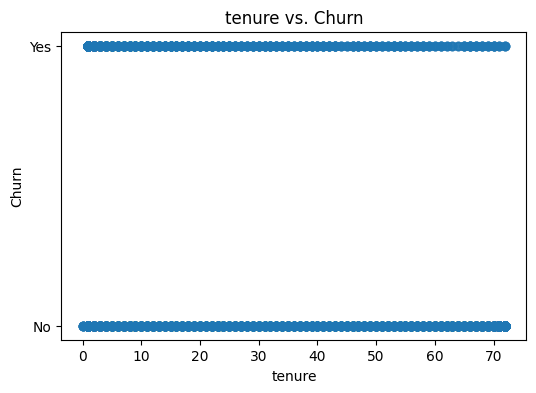

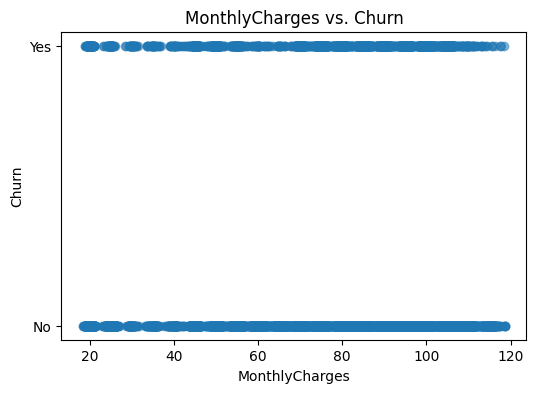

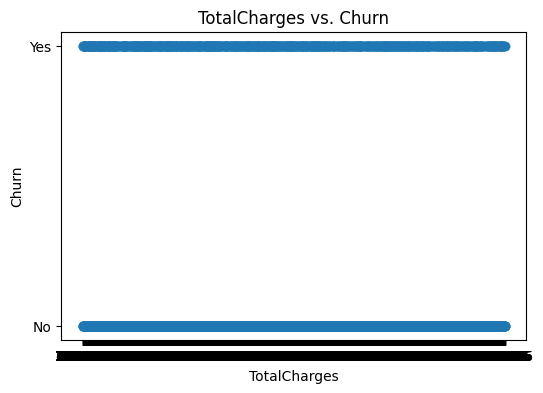

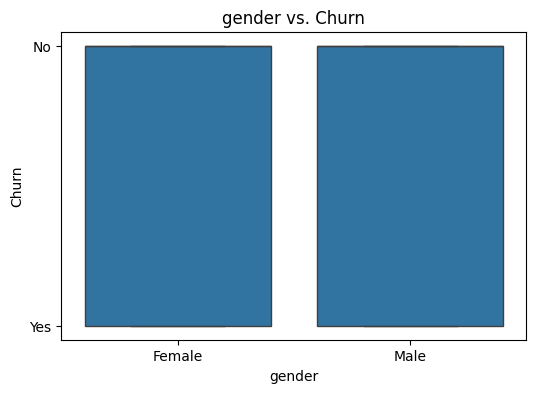

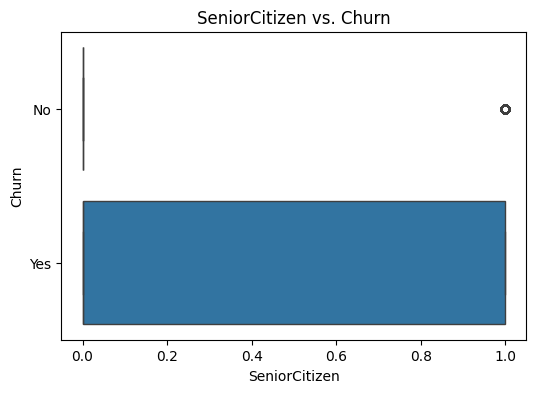

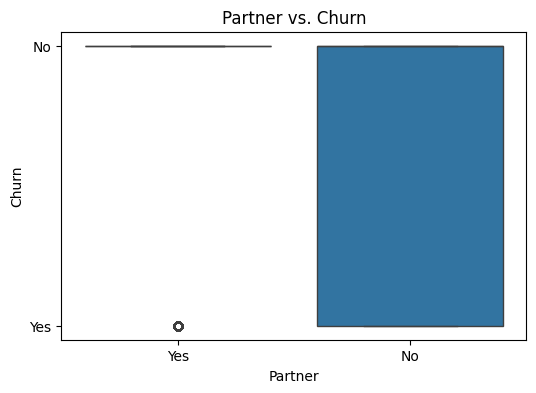

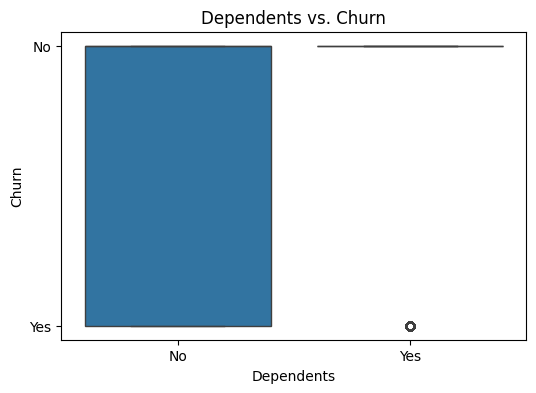

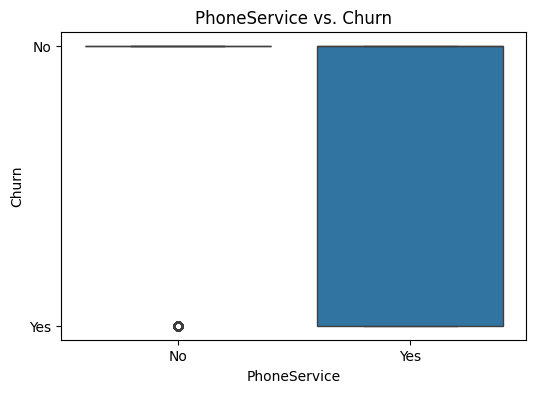

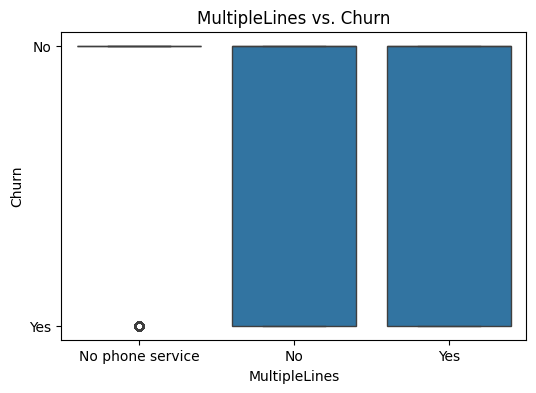

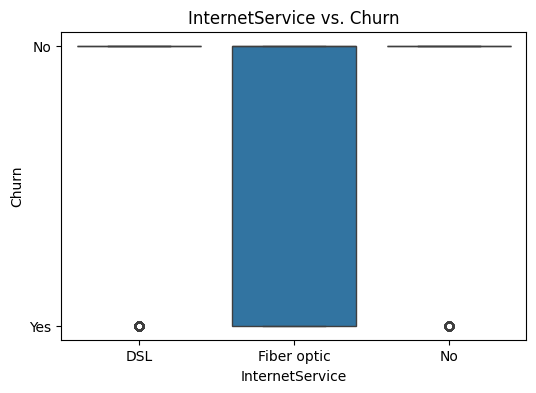

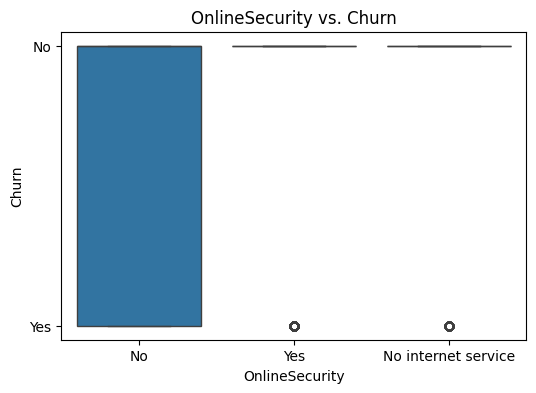

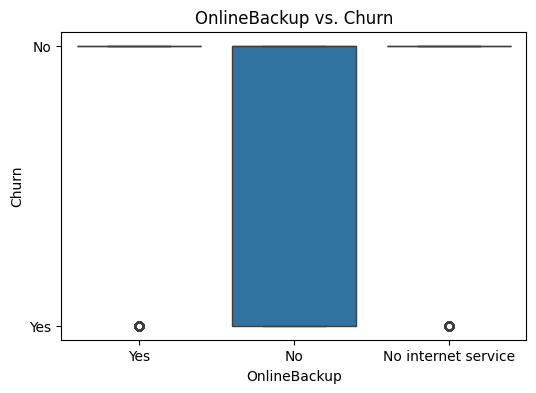

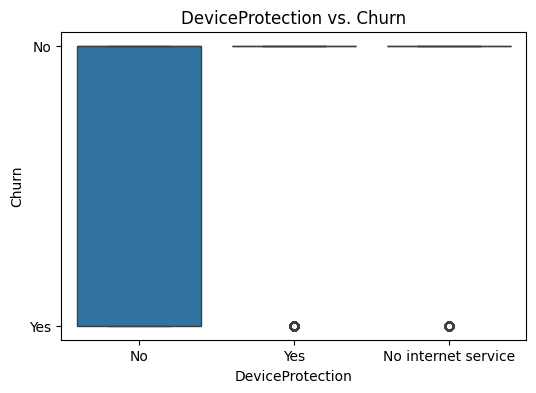

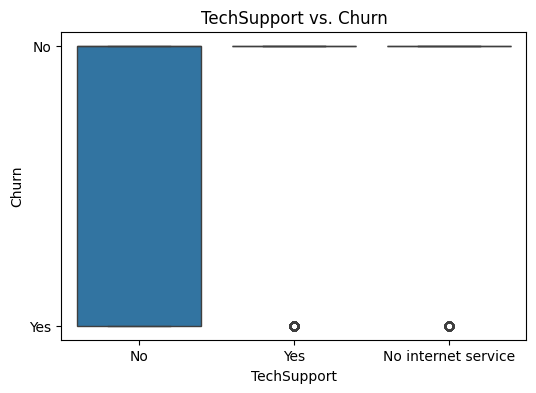

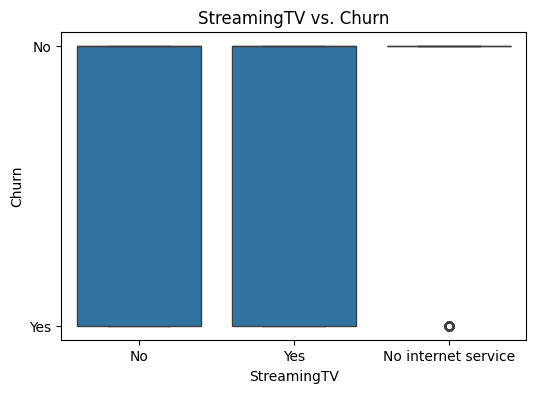

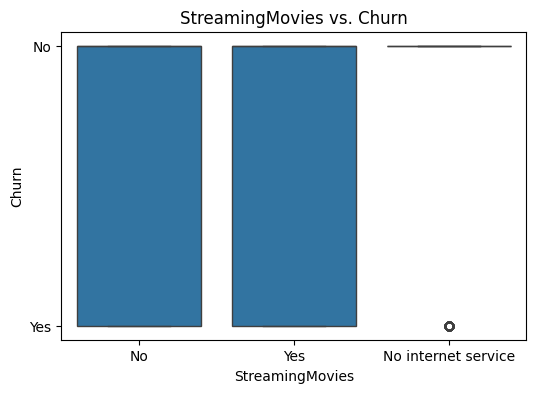

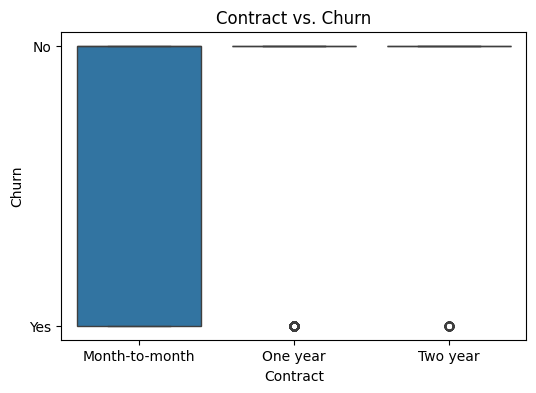

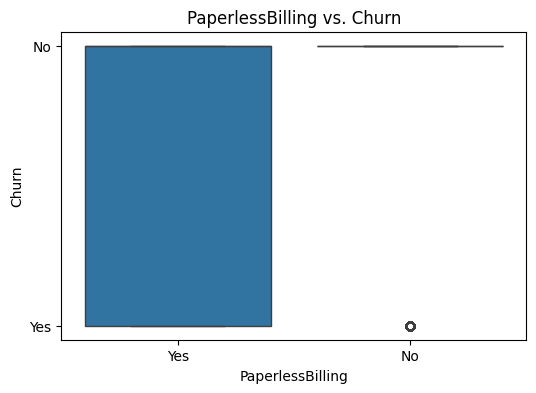

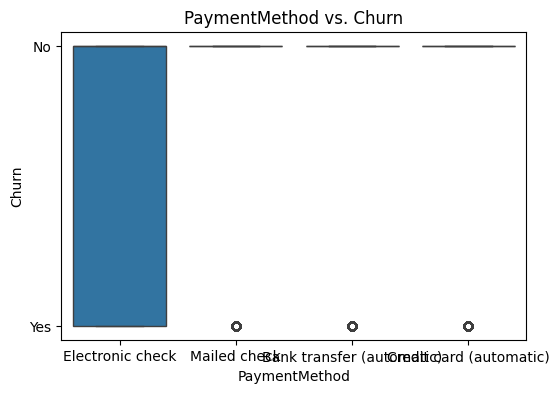

In [8]:
plot_predictors_vs_response(X, y, "Churn", num_cols)

* Create scatter plots of each predictor versus the response variable

Analysis: The scatterplot does not show any trends because there are only two values for the response variable so the scatterplots do not show a continuous trend. Therefore, it does not satisfy the linearity assumption.

In [9]:
def plot_residuals(X_train, y_train, X_test, y_test, model, name):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(len(y_pred))

  residuals = y_test - y_pred

  plt.figure(figsize=(6, 4))
  plt.scatter(y_pred, residuals)
  plt.xlabel('Predicted Values')
  plt.ylabel('Residuals')
  plt.title(f'Residual Plot - {name}')
  plt.axhline(y=0, color='r', linestyle='--')
  plt.tight_layout()
  plt.show()

1409


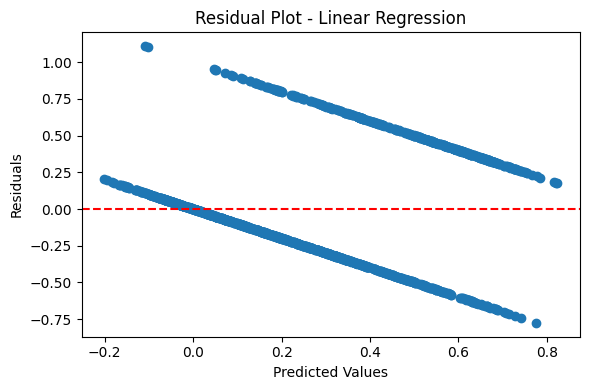

In [10]:
plot_residuals(X_train_processed, y_train, X_test_processed, y_test, LinearRegression(), "Linear Regression")

1409


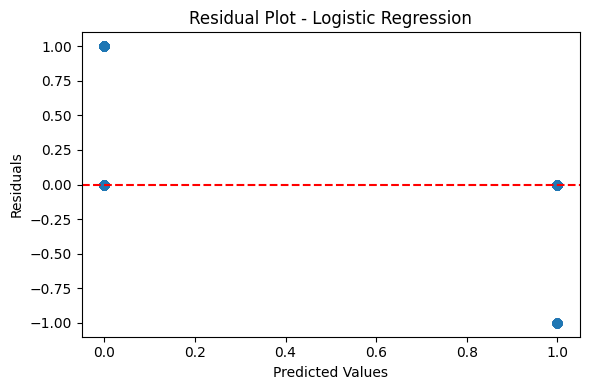

In [11]:
plot_residuals(X_train_processed, y_train, X_test_processed, y_test, LogisticRegression(), "Logistic Regression")

* Plot residuals versus predicted values (residual plot) - if relationship is non-linear, residual plot will show a curved pattern

Analysis: For linear regression, the relationship is non-linear and not continuous because the residual plot shows two linear lines instead of the residuals randomly scattered.

For logistic regression, the relationship is also non-linear because the residuals are not randomly scattered either.

####Independence of Observations
Observations should be independent of each other (no autocorrelation)

In [12]:
def calculate_dw_stat(X_train, y_train, X_test, y_test, model, name):
  #fit the model on training set and predict the y values on test set
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  residuals = y_test - y_pred #calculate the residuals
  dw_state = durbin_watson(residuals) #calculate the DW statistic
  print(f"Durbin-Watson Statistic for {name}: {dw_state:.4f}")

In [13]:
calculate_dw_stat(X_train_processed, y_train, X_test_processed, y_test, LinearRegression(), "Linear Regression")

Durbin-Watson Statistic for Linear Regression: 1.8883


In [14]:
calculate_dw_stat(X_train_processed, y_train, X_test_processed, y_test, LogisticRegression(), "Logistic Regression")

Durbin-Watson Statistic for Logistic Regression: 1.8685


* Durbin-Watson test (tests for first-order autocorrelation)

Analysis: The Durbin-Watson test detects the first-order autocorrelation in the residuals of a regression model. For linear regression, the DW statistic was calculated at 1.8883, since this value is close to 2 there is no autocorrelation. This means that the residuals are independent over time. So the assumption that the residuals are independent and the observations are independent is correct.

For logistic regression, the DW statistic was calculated to be 1.8685, since this value is cloase to 2 there is no autocorrelation. So the assumption that the residuals are independent and the observations are independent is correct.

####Homoscedasticity
Constant variance of residuals across all levels of predictors.

1409


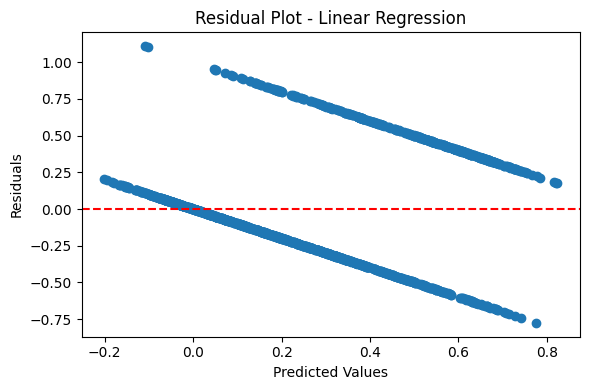

In [15]:
plot_residuals(X_train_processed, y_train, X_test_processed, y_test, LinearRegression(), "Linear Regression")

1409


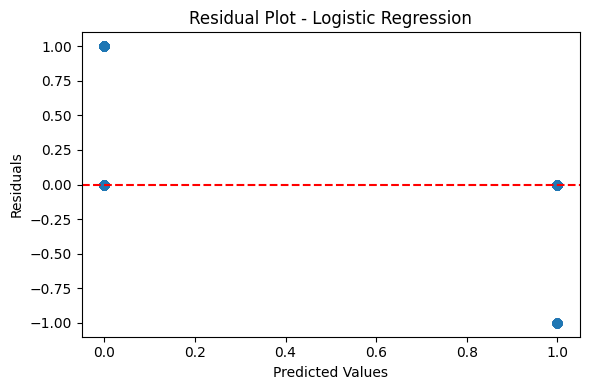

In [16]:
plot_residuals(X_train_processed, y_train, X_test_processed, y_test, LogisticRegression(), "Logistic Regression")

* Plot residuals versus predicted values
* Look for funnel patterns in residual plots (-> bad homoscedasticity)

Analysis: For linear regression, there is a linear pattern in the residual plot so there is no constant variance across the predictors. So the homoscedasticity assumption is false.

For logistic regression, there is no funnel pattern in the residual plot, and there is also no random scattering of the residuals. So the homoscedasticity assumption is false.

####Normality of Residuals
Residuals should be normally distributed

In [17]:
def q_q_plot(X_train, y_train, X_test, y_test, model, name):
  #fit the model of the training set and predict the y values on the test set
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  residuals = y_test - y_pred #calculate the residuals

  plt.figure(figsize=(6,4))
  stats.probplot(residuals, dist="norm", plot=plt)
  plt.title("Q-Q Plot of Residuals")
  plt.show()

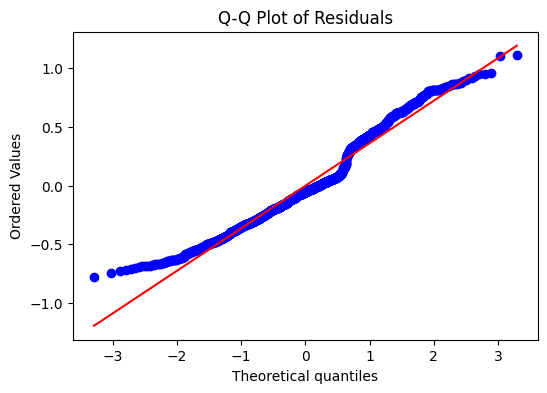

In [18]:
q_q_plot(X_train_processed, y_train, X_test_processed, y_test, LinearRegression(), "Linear Regression")

* Q-Q plot of residuals

Analysis: For linear regression, since the points roughly follow the diagonal line, the residual are normal. The assumption of normal residuals is satisfied.

In [19]:
def hist_of_residuals(X_train, y_train, X_test, y_test, model, name):
  #fit the model of the training set and predict the y values on the test set
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  residuals = y_test - y_pred #calculate the residuals

  plt.figure(figsize=(6,4))
  plt.hist(residuals, bins=10, edgecolor='k', alpha=0.7)
  plt.xlabel("Residuals")
  plt.ylabel("Frequency")
  plt.title("Histogram of Residuals")
  plt.show()

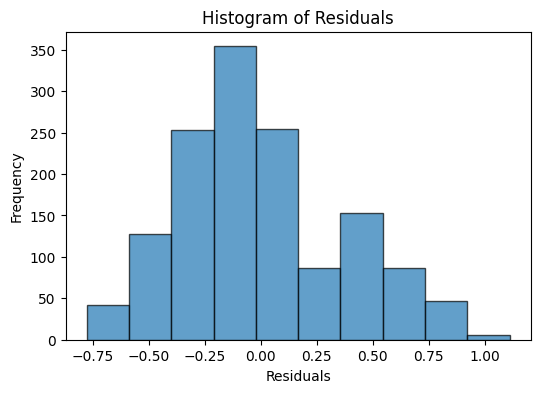

In [20]:
hist_of_residuals(X_train_processed, y_train, X_test_processed, y_test, LinearRegression(), "Linear Regression")

* Histogram of Residuals

Analysis: The histogram of the residuals do not show a heavy skew or tail, so the dataset has approximately normal residuals. The assumption of normal residuals is satisfied.

####No Multicollinearity
Predictors should not be higly correlated with each other

In [21]:
# The below code snippet was generated using GPT-5 on Sep 14 at 3:46pm
def calculate_vif(X_train):
  #remove columns with zero variance (constant values)
  X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]
  vif_data = pd.DataFrame()
  #calculate VIF for each feature
  vif_data["feature"] = X_train.columns
  vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
  print(f"Variance Inflation Factor: {vif_data}")

In [22]:
calculate_vif(X_train_processed)

Variance Inflation Factor:                                   feature         VIF
0                                  tenure    7.512711
1                          MonthlyCharges  874.575399
2                            TotalCharges   10.856614
3                             gender_Male    1.002744
4                         SeniorCitizen_1    1.150354
5                             Partner_Yes    1.459541
6                          Dependents_Yes    1.381179
7                        PhoneService_Yes  361.113327
8          MultipleLines_No phone service  152.902145
9                       MultipleLines_Yes    7.379836
10            InternetService_Fiber optic  149.990429
11                     InternetService_No  104.825218
12                     OnlineSecurity_Yes    6.459489
13                       OnlineBackup_Yes    6.879792
14                   DeviceProtection_Yes    6.989084
15                        TechSupport_Yes    6.542412
16                        StreamingTV_Yes   24.459954
1

In [23]:
def drop_high_collinear_features(X_train):
  return X_train.drop(columns=['MonthlyCharges', 'PhoneService_Yes', 'MultipleLines_No phone service', 'InternetService_Fiber optic', 'InternetService_No', 'StreamingTV_Yes', 'StreamingMovies_Yes'])

* Variance Inflation Factor (VIF)

Analysis: The VIF results show that some features have high multicollinearity where their VIF values are a large number. So I'll be removing the features that have a VIF larger than 11: ['MonthlyCharges', 'PhoneService_Yes', 'MultipleLines_No phone service', 'InternetService_Fiber optic', 'InternetService_No', 'StreamingTV_Yes', 'StreamingMovies_Yes']. After dropping these features, the dataset should be able to satisfy the assumption of no multicollinearity.

####No Influential Outliers
No single observation should have undue influence on the model.

In [24]:
# The below code snippet was generated using GPT-5 on Sep 14 at 4:12pm
def cooks_distance(X_train, y_train):
  #creates an ordinary least squares regression model to train/calculate the distance
  X = sm.add_constant(X_train)
  model = sm.OLS(y_train, X_train).fit()
  cooks_d, _ = model.get_influence().cooks_distance

  plt.figure(figsize=(6,4))
  plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
  plt.axhline(4/len(X), color="r", linestyle="--", label="Threshold: 4/n")
  plt.xlabel("Observation index")
  plt.ylabel("Cook's distance")
  plt.title("Cook's Distance Plot")
  plt.legend()
  plt.show()

  influential_points = np.where(cooks_d > 0.00125)[0]
  print("Influential observations:", influential_points)

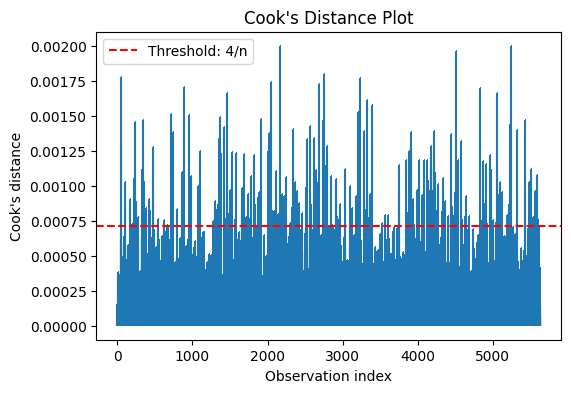

Influential observations: [  48   50  231  339  472  713  737  893  958 1348 1370 1373 1418 1458
 1916 2023 2050 2168 2346 2532 2562 2618 2685 2741 2758 2794 3208 3226
 3291 3329 3388 3906 3913 4182 4218 4451 4518 4579 4831 5053 5237 5241
 5325 5430]


In [25]:
cooks_distance(X_train_processed, y_train)

* No Influential Outliers

Analysis: The Cook's distance plot shows that there are a lot of data points that are influential (above the 4/n threshold). So it is not out of the ordinary that a data point is too influential. Since no influential outliers assumption means that all observations contribute relevantly equally, removing the observations that have a cook's distance higher than 0.00125 will satisfy the assumption better.

In [26]:
drop_high_collinear_features(X_train_processed)
drop_high_collinear_features(X_test_processed)

,tenure,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
185,-1.284605,-0.999687,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2715,0.353238,-0.570322,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3825,0.803645,-0.554746,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1807,-1.284605,-0.976907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132,1.417836,0.429966,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366,1.294997,0.924311,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
315,0.762699,1.502128,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2439,-0.629468,-0.864932,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5002,1.499728,0.297399,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


###Linear Regression
Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.

Strengths of Linear Regression:
* How predictions work is transparent
* Lots of documentaiton on the model
* Based on solid statistical theory

Weaknesses of Linear Regression:
* Can only represent linear relationships
* Usually not accurate because the real world data is typically complex and nonlinear
* the interpretation of a weight is dependent on other features

In [27]:
def model_linear_reg(X_train, y_train, X_test, y_test):
  model = LinearRegression() #create linear reg model
  model.fit(X_train, y_train) #fit the model on the training X and y
  y_pred = model.predict(X_test) #using the fitted model, predict the y values on the X test set
  mse = mean_squared_error(y_test, y_pred) #calculate the mean squared error
  r2 = r2_score(y_test, y_pred) #calculate the R^2 score

  #print the model's performance
  print(f"\nLinear Regression:")
  print(f"MSE: {mse:.2f}")
  print(f"R2 Score: {r2:.2f}")

  #print the model's coefficients
  for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

In [28]:
model_linear_reg(X_train_processed, y_train, X_test_processed, y_test)


Linear Regression:
MSE: 0.13
R2 Score: 0.31
tenure: -0.0471
MonthlyCharges: -0.1347
TotalCharges: -0.0943
gender_Male: -0.0086
SeniorCitizen_1: 0.0377
Partner_Yes: 0.0070
Dependents_Yes: -0.0233
PhoneService_Yes: 0.0269
MultipleLines_No phone service: -0.0269
MultipleLines_Yes: 0.0713
InternetService_Fiber optic: 0.2816
InternetService_No: -0.2556
OnlineSecurity_Yes: -0.0351
OnlineBackup_Yes: -0.0010
DeviceProtection_Yes: 0.0218
TechSupport_Yes: -0.0269
StreamingTV_Yes: 0.0883
StreamingMovies_Yes: 0.1073
Contract_One year: -0.1077
Contract_Two year: -0.0818
PaperlessBilling_Yes: 0.0454
PaymentMethod_Credit card (automatic): -0.0043
PaymentMethod_Electronic check: 0.0707
PaymentMethod_Mailed check: -0.0039


The mean squared error of this Linear Regression model is 0.13. This calculates the squared error between the predicted y value and the actual y value on average. A small (closer to 0) MSE means the model is a better fit.
The R^2 is 0.31, which means that the model explains 31% of variance in the predicted y value for Churn. A good model fit is closer to 1.

Each coefficient value is associated with the weight or influence of the feature on being able to predict the response variable of Churn.
A positive coefficient means the feature value increases the predicted churn. For example, SeniorCitizen_1 = 0.0377 which means that being senior citizens are more probable of churn. A negative coefficient means the feature value decreases the predicted churn. For example, tenure = -0.0471 means that a longer tenure is less likely to churn.
A larger magnitude of the coefficient means that the feature is more influential on the prediction of churn.

###Logistic Regression
Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.

Strengths of Logistic Regression:
* How predictions work is transparent
* Lots of documentaiton on the model
* Based on solid statistical theory
* Can give you probabilities in addition to classification

Weaknesses of Logistic Regression:
* Can only represent linear relationships
* Usually not accurate because the real world data is typically complex and nonlinear
* Interpretation is more difficult than linear regression because the interpretation of the weights is multiplicative and not additive
* If there is a feature that would perfectly separate the two classes, the weight for that feature would not converge and the model wouldn't be able to be trained

In [29]:
def model_logistic_reg(X_train, y_train, X_test, y_test):
  model = LogisticRegression() #create a logistic regression
  model.fit(X_train, y_train) #fit the model on the training X and y
  y_pred = model.predict(X_test) #predict the y value on the test set
  mse = mean_squared_error(y_test, y_pred) #calculate the mean squared error
  r2 = r2_score(y_test, y_pred) #calculate the R^2 score
  precision = precision_score(y_test, y_pred) #calculate the precision
  recall = recall_score(y_test, y_pred) #calculate the recall

  #print the model's performance
  print(f"\nLogistic Regression:")
  print(f"MSE: {mse:.2f}")
  print(f"R2 Score: {r2:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")

  #print the model's coefficients
  #print(model.coef_)
  for feature, coef in zip(X_train.columns, model.coef_[0]):
    print(f"{feature}: {coef:.4f}")

In [30]:
model_logistic_reg(X_train_processed, y_train, X_test_processed, y_test)


Logistic Regression:
MSE: 0.18
R2 Score: 0.08
Precision: 0.69
Recall: 0.60
tenure: -1.3550
MonthlyCharges: -0.1328
TotalCharges: 0.6493
gender_Male: -0.0530
SeniorCitizen_1: 0.1602
Partner_Yes: 0.0541
Dependents_Yes: -0.1634
PhoneService_Yes: -0.5505
MultipleLines_No phone service: 0.0185
MultipleLines_Yes: 0.2597
InternetService_Fiber optic: 0.8412
InternetService_No: -0.8591
OnlineSecurity_Yes: -0.4312
OnlineBackup_Yes: -0.1756
DeviceProtection_Yes: -0.0244
TechSupport_Yes: -0.3510
StreamingTV_Yes: 0.2006
StreamingMovies_Yes: 0.3069
Contract_One year: -0.6350
Contract_Two year: -1.3869
PaperlessBilling_Yes: 0.3347
PaymentMethod_Credit card (automatic): -0.0828
PaymentMethod_Electronic check: 0.3268
PaymentMethod_Mailed check: -0.0296


The mean squared error of this Linear Regression model is 0.18. This calculates the squared error between the predicted y value and the actual y value on average. A small (closer to 0) MSE means the model is a better fit.
The R^2 is 0.08, which means that the model explains 8% of variance in the predicted y value for Churn. A good model fit is closer to 1.
The precision score is 0.69, which means that out of all the customers that the model predicted will churn, only 69% of customers actually did churn.
The recall score is 0.60, which means that out of all customers who actually did churn, 60% of customers were predicted would churn.

Each coefficient value is associated with the weight or influence of the feature on being able to predict the response variable of Churn. Specifically, the log-odds change for every unit change of the feature value.
A coefficient that is negative means the feature value decreases the predictability of churn. For example, tenure = -1.3550 which means that a longer tenure decreases the probability of churn. A positive coefficient means the feature value increases the predicted churn. For example, TotalCharges = 0.6493 means that a larger total charge is more likely to churn.

###Generalized Additive Model
Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.

Strengths of GAM:
* How predictions work is transparent
* Lots of documentaiton on the model
* Based on solid statistical theory
* Allows nonlinear relationships to be modeled

Weaknesses of GAM:
* Most modifications of the linear model make the model less interpretable

In [31]:
def model_gam(X_train, y_train, X_test, y_test):
  X_train, X_test = X_train.values, X_test.values
  y_train, y_test = y_train.values, y_test.values

  #s() creates the spline function for each feature in the training set
  gam = LinearGAM(
        sum([s(i) for i in range(X_train.shape[1])], start=s(0))
    )

  #finds the best smoothing parameters for each spline term
  gam.gridsearch(X_train, y_train)

  #fits the model on the training X and y
  gam.fit(X_train, y_train)

  #predict the y values on the test set
  y_pred_gam = gam.predict(X_test)

  #calculate MSE and R^2
  mse_gam = mean_squared_error(y_test, y_pred_gam)
  r2_gam = r2_score(y_test, y_pred_gam)

  print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

  gam.summary()

In [32]:
model_gam(X_train_processed, y_train, X_test_processed, y_test)
#num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
#model_gam(X_train_processed[num_cols].values, y_train, X_test_processed[num_cols].values, y_test)

100% (11 of 11) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


GAM MSE: 0.1304, R^2: 0.3301
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     43.1012
Link Function:                     IdentityLink Log Likelihood:                                -14458.9559
Number of Samples:                         5634 AIC:                                            29006.1141
                                                AICc:                                           29006.8259
                                                GCV:                                                0.1382
                                                Scale:                                              0.1363
                                                Pseudo R-Squared:                                   0.3065
Feature 

/tmp/ipython-input-3874206886.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


The mean squared error of this Linear Regression model is 0.1304. This calculates the squared error between the predicted y value and the actual y value on average. A small (closer to 0) MSE means the model is a better fit.
The R^2 is 0.331, which means that the model explains 33% of variance in the predicted y value for Churn. A good model fit is closer to 1.

The each s(i) represents the spline for feature i. the Effective Degrees of Freedom (EDoF) describes how curved the function is. A value closer to 1 means that the spline was basically linear, while a value closer to 0 means the spline was more curved.
The P>x value describes how influential the feature is. The smaller value is the strong the influence the feature has on the model fit. For example, s(0) is significantly affects the response.

###Recommendation
**The telecommunications company should use the General Additive Model to address their cutomer churn problem.**
As shown by the EDA for the Linearity assumption, the dataset is not a linear relationship. Out of the three models, only GAM is able to appropriately model nonlinear relationships.

Additionally, the summary data from the GAM can tell the company which features are most influential in affecting the churn response variable with the P > x metric value as explained in the interpretation of the GAM model. This helps the company to focus on certain attributes of the customer to limit the churn, for example, tenure or contract type.
